In [1]:
import pandas as pd
from mendeleev import element
import numpy as np
import pickle as pickle
import matplotlib.pyplot as plt
import pymatgen as mg
from pymatgen.ext.matproj import MPRester
import seaborn as sns
import matplotlib.pyplot as plt


In [3]:
# from a pandas dataframe from a pkl file.

with open("C:\\RPI\\MI2DMaterials\\BiLayer\\code\\file\\AAX_bilayer_data_dump_5.10.21.pkl", "rb") as f:
    data = pickle.load(f)
    
df  = pd.DataFrame(data)


In [4]:
# make another dataframe with only the jobs that are finished
count_row = df.shape[0]  # Gives number of rows
count_col = df.shape[1]  # Gives number of columns
print('Total Jobs')
print(count_row)
print(df.state.unique())

df = df[df['state']=='JOB_FINISHED'].reset_index()

Total Jobs
695
['FAILED' 'JOB_FINISHED' 'AWAITING_PARENTS' 'RESTART_READY' 'RUN_TIMEOUT'
 'PREPROCESSED']


In [ ]:
# Calculate the magnetic moment first , else the magnetization column was changing from list to string 
# df = df[df['state']=='JOB_FINISHED'].reset_index() is a very helful thing 

In [6]:
# vaishnavi's code modified to get total magnetic moment 
# if name == 'initial' or 'spin' or  'afm': only x is present , take the most relaxed one [-1] = magmom
    # [-1][2] will give only the " s', 'p', 'd', 'tot' " data without header = magmom_x
    # magmom_x_sites_tot is a list containing  all the total values  
    # magmom_x_unitcell is the sum of all these total values 
# if name == ''spin_so' or 'afm_so' : has spin over coupling :has magnetic moment in all x, y and z direction 
    # repeat same as above for all x, y and z 


def get_magnetic_moment(df):
    """ parse magnetization value from magnetization raw data """
    
#     df['magmom_sites_tot'] = np.nan
    df['magmom_unitcell_x'] = np.nan
    df['magmom_unitcell_y'] = np.nan
    df['magmom_unitcell_z'] = np.nan
    df['magmom_total'] = np.nan
    
    for i in range(len(df)):
        magmom_sites_tot = np.nan
        magmom_unitcell = np.nan
        #print(type(df['data'][i]))
        if ('magnetization' in df['data'][i]):
            raw_magmom = df['data'][i]['magnetization']

            if df.name[i] == 'initial' or df.name[i] == 'spin' or df.name[i] == 'afm':
                magmom = raw_magmom[-1]
                magmom_x = magmom[2]

                if isinstance(magmom_x[0], list):
                    magmom_x_sites_tot = [x[-1] for x in magmom_x]
                else:
                    magmom_x_sites_tot = [x[-1] for x in magmom]
                    
                magmom_x_unitcell = np.sum(magmom_x_sites_tot)
                magmom_sites_tot = magmom_x_sites_tot
                
                df['magmom_unitcell_x'][i] = abs(magmom_x_unitcell)
                df['magmom_total'][i] = abs(magmom_x_unitcell)
                
#                 df['magmom_sites_tot'][i] = magmom_sites_tot

                
            elif df.name[i] == 'spin_so' or df.name[i] == 'afm_so':
                magmom = raw_magmom[-3:]
                magmom_x = magmom[0][2]
                magmom_y = magmom[1][2]
                magmom_z = magmom[2][2]

                if isinstance(magmom_x[0], list):
                    magmom_x_sites_tot = [x[-1] for x in magmom_x]
                    magmom_x_unitcell = np.sum(magmom_x_sites_tot)
                else:
                    magmom_x_sites_tot = magmom_x
                    magmom_x_unitcell = magmom_x

                if isinstance(magmom_y[0], list):
                    magmom_y_sites_tot = [x[-1] for x in magmom_y]
                    magmom_y_unitcell = np.sum(magmom_y_sites_tot)
                else:
                    magmom_y_sites_tot = magmom_y
                    magmom_y_unitcell = magmom_y

                if isinstance(magmom_z[0], list):
                    magmom_z_sites_tot = [x[-1] for x in magmom_z]
                    magmom_z_unitcell = np.sum(magmom_z_sites_tot)
                else:
                    magmom_z_sites_tot = magmom_z
                    magmom_z_unitcell = magmom_z

                magmom_sites_tot = np.asarray([magmom_x_sites_tot, magmom_y_sites_tot, magmom_z_sites_tot], object)
                
                total_moment_sum = np.square(magmom_x_unitcell) + np.square(magmom_y_unitcell) + np.square(magmom_z_unitcell) 
                total_moment_temp = np. sqrt(total_moment_sum)
                df['magmom_unitcell_x'][i] = abs(magmom_x_unitcell)
                df['magmom_unitcell_y'][i] = abs(magmom_y_unitcell)
                df['magmom_unitcell_z'][i] = abs(magmom_z_unitcell)
                df['magmom_total'][i] = abs(total_moment_temp)
#                 df['magmom_sites_tot'][i] = magmom_sites_tot

    return df         


In [7]:
# add 4 columns with magnetic values x, y , z and total 
df = get_magnetic_moment(df)

<ipython-input-6-bba31bb9c5bb>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['magmom_unitcell_x'][i] = abs(magmom_x_unitcell)
<ipython-input-6-bba31bb9c5bb>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['magmom_total'][i] = abs(magmom_x_unitcell)
<ipython-input-6-bba31bb9c5bb>:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['magmom_unitcell_x'][i] = abs(magmom_x_unitcell)
<ipython-input-6-bba31bb9c5bb>:76: SettingWit

In [8]:
df_finished = df[df['state']=='JOB_FINISHED']

In [9]:
# check for how many structures the calculation is finished
# add two rows with the stacking details and formula
print(len(df_finished))
print(len(df_finished.workflow.unique()))
df_finished[['Formula','Stacking']] = df_finished.workflow.str.split(",",expand=True)
print(df_finished.Formula.unique())
print(len(df_finished.workflow.unique()))
# 57 unique formula 

310
110
['Ir4Cl12' 'Zr2Ti2I12' 'Ti2Fe2Cl12' 'Ti4Br12' 'Zr2Ti2Cl12' 'Ni2Ir2Cl12'
 'Mo2Ir2Br12' 'Zr2Ti2Br12' 'Cr2Ir2Br12' 'Ti2Ni2Br12' 'Cd2Ir2I12'
 'Mo2Ir2Cl12' 'Ti2Ru2Cl12' 'Ti2Ni2Cl12' 'Cd2Ir2Br12' 'Ir2Ru2I12'
 'Ir2Ru2Cl12' 'Ir2Pd2Cl12' 'Ti4I12' 'Ir2Ru2Br12' 'Ti2Fe2I12' 'Fe2Ir2I12'
 'Ti2Au2I12' 'Ir2Au2Br12' 'Ti2Zn2Cl12' 'Ti2Ni2I12' 'Ti2Ir2I12' 'Ir2Pd2I12'
 'Ir4Br12' 'Ti2Mo2I12' 'Cr2Ir2I12' 'Ti4Cl12' 'Ti2Ru2Br12' 'Ti2Cd2Cl12'
 'Ti2Cd2I12' 'Mo2Ir2I12' 'Ti2Pd2Br12' 'Ti2Pd2I12' 'Ti2Au2Cl12'
 'Fe2Ir2Cl12' 'Ir4I12' 'Zn2Ir2Cl12' 'Zr2Ir2Cl12' 'Ti2Cd2Br12' 'Ni2Ir2Br12'
 'Ti2Ru2I12' 'Ni2Ir2I12' 'Ti2Cr2Br12' 'Zn2Ir2Br12' 'Zr2Ir2Br12'
 'Fe2Ir2Br12' 'Ti2Zn2Br12' 'Ti2Pd2Cl12' 'Ti2Cr2Cl12' 'Ti2Cr2I12'
 'Zr2Ir2I12' 'Ti2Zn2I12' 'Ti2Au2Br12' 'Cr2Ir2Cl12' 'Ir2Au2Cl12'
 'Zn2Ir2I12' 'Ir2Au2I12' 'Ti2Fe2Br12' 'Cd2Ir2Cl12' 'Ir2Pd2Br12']
110


In [10]:
df.to_csv('AAX_RAW.csv')

In [11]:
# get an idea of how many jobs finihsed for each structure
from collections import Counter
#c = Counter(list(zip(df_finished.Stacking, df_finished.Formula)))
c = Counter(list(zip(df_finished.Formula)))
#print(c)
print(type(c))
dict_count = dict(c)
#print(type(str(dict_count.keys)))

dict_count_temp = []
for key, val in dict_count.items():
    dict_count_temp.append(str([key])+ str(val))

#print(type(str(dict_count_temp)))
print(dict_count_temp[0])
dict_with_job_count = {}

count = 0 

for temp in dict_count_temp:
    #print(temp)
    val = temp[-1:]
    count = count + int(val)
    key_temp = temp[3: temp.rfind(',')]
    key = key_temp.replace("'", "")
    #print(val)
    dict_with_job_count.update({key: val})
print("\n No. of jobs for each structure")
print(dict_with_job_count)

print("\n No. of unique structure")

print(len(dict_with_job_count))

print("\n Total count of finished jobs")

print(count)

<class 'collections.Counter'>
[('Ir4Cl12',)]9

 No. of jobs for each structure
{'Ir4Cl12': '9', 'Zr2Ti2I12': '3', 'Ti2Fe2Cl12': '2', 'Ti4Br12': '8', 'Zr2Ti2Cl12': '3', 'Ni2Ir2Cl12': '4', 'Mo2Ir2Br12': '4', 'Zr2Ti2Br12': '5', 'Cr2Ir2Br12': '5', 'Ti2Ni2Br12': '4', 'Cd2Ir2I12': '6', 'Mo2Ir2Cl12': '5', 'Ti2Ru2Cl12': '5', 'Ti2Ni2Cl12': '8', 'Cd2Ir2Br12': '5', 'Ir2Ru2I12': '8', 'Ir2Ru2Cl12': '2', 'Ir2Pd2Cl12': '5', 'Ti4I12': '3', 'Ir2Ru2Br12': '4', 'Ti2Fe2I12': '2', 'Fe2Ir2I12': '2', 'Ti2Au2I12': '3', 'Ir2Au2Br12': '5', 'Ti2Zn2Cl12': '0', 'Ti2Ni2I12': '3', 'Ti2Ir2I12': '2', 'Ir2Pd2I12': '2', 'Ir4Br12': '0', 'Ti2Mo2I12': '1', 'Cr2Ir2I12': '6', 'Ti4Cl12': '7', 'Ti2Ru2Br12': '4', 'Ti2Cd2Cl12': '8', 'Ti2Cd2I12': '5', 'Mo2Ir2I12': '5', 'Ti2Pd2Br12': '6', 'Ti2Pd2I12': '2', 'Ti2Au2Cl12': '4', 'Fe2Ir2Cl12': '4', 'Ir4I12': '5', 'Zn2Ir2Cl12': '6', 'Zr2Ir2Cl12': '5', 'Ti2Cd2Br12': '7', 'Ni2Ir2Br12': '5', 'Ti2Ru2I12': '6', 'Ni2Ir2I12': '6', 'Ti2Cr2Br12': '2', 'Zn2Ir2Br12': '4', 'Zr2Ir2Br12': '5', 'Fe2Ir

In [12]:
df.columns

Index(['index', '_state', 'job_id', 'workflow', 'name', 'description', 'lock',
       'tick', 'parents', 'input_files', 'stage_in_url', 'stage_out_files',
       'stage_out_url', 'wall_time_minutes', 'num_nodes',
       'coschedule_num_nodes', 'ranks_per_node', 'cpu_affinity',
       'threads_per_rank', 'threads_per_core', 'node_packing_count',
       'environ_vars', 'application', 'args', 'user_workdir',
       'wait_for_parents', 'post_error_handler', 'post_timeout_handler',
       'auto_timeout_retry', 'state', 'state_history', 'queued_launch_id',
       'data', 'magmom_unitcell_x', 'magmom_unitcell_y', 'magmom_unitcell_z',
       'magmom_total'],
      dtype='object')

In [13]:
# data contains a dictionary of DFT results 
# check the contents of this dictionary 
df_filtered_finished_data = df_finished[['Formula', 'Stacking', 'name', 'data','magmom_unitcell_x', 'magmom_unitcell_y', 'magmom_unitcell_z',
       'magmom_total']].copy()
#df_filtered_finished_data
#print(type(df_filtered_finished_data.iloc[0]['data']))
#print("\n Types of DFT data")
#print(df_filtered_finished_data.iloc[0]['data'].keys())
#print("\n DFT data : LOOP+")
#print(df_filtered_finished_data.iloc[0]['data'].get('LOOP+'))
#print("\n DFT data : NIONS")
#print(df_filtered_finished_data.iloc[0]['data'].get('NIONS'))
#print("\n DFT data : NKDIM")
#print(df_filtered_finished_data.iloc[0]['data'].get('NKDIM'))
#print("\n DFT data : NBANDS")
#print(df_filtered_finished_data.iloc[0]['data'].get('NBANDS'))
#print("\n DFT data : energy")
#print(df_filtered_finished_data.iloc[0]['data'].get('energy'))
#print("\n DFT data : stress")
#print(df_filtered_finished_data.iloc[0]['data'].get('stress'))
#print("\n DFT data : retry_count")
#print(df_filtered_finished_data.iloc[0]['data'].get('retry_count'))
#print("\n DFT data : lattice_vecs")
#print(df_filtered_finished_data.iloc[0]['data'].get('lattice_vecs'))
#print("\n DFT data : total charge")
#print(df_filtered_finished_data.iloc[0]['data'].get('total charge'))
#print("\n DFT data : magnetization")
#print(df_filtered_finished_data.iloc[0]['data'].get('magnetization'))
#print("\n DFT data : position_force")
#print(df_filtered_finished_data.iloc[0]['data'].get('position_force'))
#print("\n DFT data : volume of cell")
#print(df_filtered_finished_data.iloc[0]['data'].get('volume of cell'))

In [14]:
count_row = df_filtered_finished_data.shape[0]  # Gives number of rows
count_col = df_filtered_finished_data.shape[1]  # Gives number of columns
print(count_row)

310


In [15]:

def parse_data_to_form_columns(df):
    
    #input: dataframe containing the energy data
    
    #output: input dataframe with added columns from the 'data' column i.e. energy, LOOP+, etc.
    
    rownum = 0
    rownum = len(df)
    print(rownum) # number of rows in the dataframe
    
    loop= []
    nions= []
    nkdim= []
    nbannds= []
    energy= []
    stress= []
    retry= []
    lattice_vecs= []
    charge= []
    magnetization= []
    position_force= []
    vol= []
    
    
    

    for i in range(rownum) :
        loop.append(df.iloc[i]['data'].get('LOOP+'))
        nions.append(df.iloc[i]['data'].get('NIONS'))
        nkdim.append(df.iloc[i]['data'].get('NKDIM'))
        nbannds.append(df.iloc[i]['data'].get('NBANDS'))
        energy.append(df.iloc[i]['data'].get('energy'))
        stress.append(df.iloc[i]['data'].get('stress'))
        retry.append(df.iloc[i]['data'].get('retry_count'))
        lattice_vecs.append(df.iloc[i]['data'].get('lattice_vecs'))
        charge.append(df.iloc[i]['data'].get('total charge'))
        magnetization.append(df.iloc[i]['data'].get('magnetization'))
        position_force.append(df.iloc[i]['data'].get('position_force'))
        vol.append(df.iloc[i]['data'].get('volume of cell'))
   
    df['LOOP+'] = loop
    df['NIONS'] = nions
    df['NKDIM'] = nkdim
    df['NBANDS'] = nbannds
    df['energy'] = energy
    df['stress'] = stress
    df['retry_count'] = retry
    df['lattice_vecs'] = lattice_vecs
    df['total charge'] = charge
    df['magnetization'] = magnetization
    df['position_force'] = position_force
    df['volume of cell'] = vol
    return df

In [16]:
parse_data_to_form_columns(df_filtered_finished_data)
df_filtered_finished_data.columns
# Index(['Formula', 'Stacking', 'name', 'data'], dtype='object')


310


Index(['Formula', 'Stacking', 'name', 'data', 'magmom_unitcell_x',
       'magmom_unitcell_y', 'magmom_unitcell_z', 'magmom_total', 'LOOP+',
       'NIONS', 'NKDIM', 'NBANDS', 'energy', 'stress', 'retry_count',
       'lattice_vecs', 'total charge', 'magnetization', 'position_force',
       'volume of cell'],
      dtype='object')

In [17]:
# Take the most relaxed energy , if the energy is a list take the last one , if float keep it
def get_energy_data(df):
    """Get the dataframe as an input and get the energy data present in the 'data' 
    column of the dataframe to retrieve the most relaxed energy for that material.
    """
    rownum = len(df)
    relaxed_Energy = []
    for i in range(rownum) :
        if isinstance(df.iloc[i]['energy'],list):
            energy_temp = []
            energy_temp = df.iloc[i]['energy']
            relaxed_Energy.append(energy_temp[-1])
        else:
            relaxed_Energy.append(df.iloc[i]['energy'])
            
    df['relaxed_Energy'] = relaxed_Energy 
    return df

In [18]:
df_filtered_finished_data = get_energy_data(df_filtered_finished_data)
count_row = df_filtered_finished_data.shape[0]  # Gives number of rows
count_col = df_filtered_finished_data.shape[1]  # Gives number of columns
print(count_row)

310


In [19]:
mprest = MPRester('PzoyfeSvTTxngtLA')

In [20]:
def get_sum_individual_energies(df):

    # Add coulms with 'sum_individual_energy' , 'elements_present', and  composition. 
    # sum_individual_energy = sum of energy per atom (min) from materials projects for each formula
    # elements_present is a list of elements
    # composition is a dictionary with keys as elements and value as its count.
    
    rownum = len(df)
    sum_individual_energy = []
    elements_present = []
    composition = []

    for i in range(rownum) :
        formula = df.iloc[i]['Formula']
        arr_of_elements = mg.Composition(formula)
        num_of_elements = arr_of_elements.get_el_amt_dict()
        
        # num_of_elements is a dictionary Ir4Cl12 : {'Ir': 4.0, 'Cl': 12.0})
        
        elements_present.append(list(num_of_elements.keys()))
        composition.append(dict(num_of_elements))
        
        sum_individual_energies = 0
        # Ir -8.83  cl - 7.39
        for elem in arr_of_elements:
            en = mprest.get_data(elem) # has all values from material projects
            en = [x['energy_per_atom'] for x in en] # has multiple energies
            #if en:
            en = np.min(en)*num_of_elements[str(elem)] # choose the lowest energy and multiply with no.of atoms
            #else:
                #en = -0.142        
            sum_individual_energies = sum_individual_energies + en
        
        sum_individual_energy.append(sum_individual_energies)
    
    df['sum_individual_energy'] = sum_individual_energy 
    df['elements_present'] = elements_present 
    df['composition'] = composition 
    print(get_sum_individual_energies)
    return df

In [21]:
df_filtered_finished_data = get_sum_individual_energies(df_filtered_finished_data)
count_row = df_filtered_finished_data.shape[0]  # Gives number of rows
count_col = df_filtered_finished_data.shape[1]  # Gives number of columns
print(count_row)

<function get_sum_individual_energies at 0x000002368375D9D0>
310


In [22]:
def get_formation_energy(df):
    # formation_energy = relaxed_Energy - sum_individual_energy
    rownum = len(df)
    formation_energy = []

    for i in range(rownum) :
        formation_energy_val = 0
        formation_energy_val_float = 0
        relaxed_Energy = df.iloc[i]['relaxed_Energy']
        sum_individual_energy = df.iloc[i]['sum_individual_energy']

        formation_energy_val = relaxed_Energy - sum_individual_energy
        #formation_energy_val_float = formation_energy_val.item()
        formation_energy.append(formation_energy_val)       
    
    df['formation_energy'] = formation_energy
    
    return df

In [23]:
df_filtered_finished_data = get_formation_energy(df_filtered_finished_data)
count_row = df_filtered_finished_data.shape[0]  # Gives number of rows
count_col = df_filtered_finished_data.shape[1]  # Gives number of columns
print(count_row)

310


In [24]:
from statistics import mean, median

formation_energy = df_filtered_finished_data['formation_energy']
#formation_energy_np = formation_energy.to_numpy(),linspace()

print(df_filtered_finished_data['formation_energy'].describe())


count    307.000000
mean     -70.995412
std       14.106502
min     -108.409707
25%      -82.195788
50%      -69.816388
75%      -60.907393
max      -43.234708
Name: formation_energy, dtype: float64


Text(0, 0.5, 'Frequency')

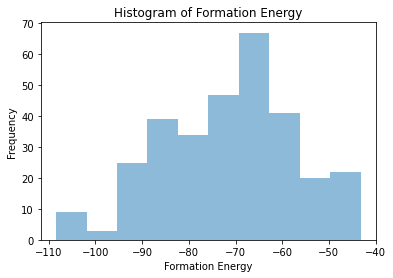

In [25]:
plt.hist(df_filtered_finished_data['formation_energy'],alpha=0.5)
plt.title('Histogram of Formation Energy')
plt.xlabel('Formation Energy')
plt.ylabel('Frequency')

In [26]:
# check for transition elements and halides in the formula

transition_elements_dict = {'Ti': 'titanium', 'V': 'vanadium','Cr': 'chromium','Mn': 'manganese','Fe': 'iron',
           'Co': 'cobalt','Ni': 'nickel','Cu': 'copper','Zr': 'zirconium','Nb': 'niobium',
           'Mo': 'molybdenum','Tc': 'technetium','Ru': 'ruthenium','Rh': 'rhodium','Pd': 'palladium',
           'Ag': 'silver','Hf': 'hafnium','Ta': 'tantalum','W': 'tungsten','Re': 'rhenium',
           'Os': 'osmium','Ir': 'iridium','Pt': 'platinum','Au': 'gold', 'Sc': 'scandium',
           'Zn': 'zinc','Y': 'yttrium','Cd': 'cadmium','Hg': 'mercury','Rf': 'rutherfordium',
           'Db': 'dubnium','Sg': 'seaborgium','Bh': 'bohrium','Hs': 'hassium','Mt': 'meitnerium',
           'Uun':'ununnilium','Uuu': 'unununium','Uub': 'unubium'}
transition_metal_symbol = list(transition_elements_dict.keys())
count = 0
for symbol in transition_metal_symbol:
    count = count +1

def classify_based_on_transition_metal( formula ):
   
   list_of_transition_metal = []
   for symbol in transition_metal_symbol:
    if(symbol in formula):
        list_of_transition_metal.append(symbol)
   return list_of_transition_metal



def has_key_in(string):
  return any(k in string for k in transition_elements_dict)

halides_dict = {'F': 'Fluoride', 'Cl': 'Chloride','Br': 'Bromide','I': 'Iodide'}
halide_symbol = list(halides_dict.keys())


def classify_based_on_halides( formula ):
   
   halides = ''
   for symbol in halide_symbol:
    if(symbol in formula):
        halides = symbol
   return halides


In [27]:
def check_for_transition_metal(df):
    # transition_element will contain a list of transition elements present
    rownum = len(df)
    transition_element = []

    for i in range(rownum) :
        tranistion_ele = []
        
        elements_present = df.iloc[i]['elements_present']
        
        tranistion_ele = classify_based_on_transition_metal(elements_present)
        
        transition_element.append(tranistion_ele)
        
    df['Transition_Element'] = transition_element
    
    return df

In [28]:
def check_for_halides(df):
    # halides will contain a halides that is present
    rownum = len(df)
    halides = []

    for i in range(rownum) :
        halide_ele = ''
        
        elements_present = df.iloc[i]['elements_present']
        
        halide_ele = classify_based_on_halides(elements_present)
        
        halides.append(halide_ele) 
        
    df['Halides'] = halides
    
    return df

In [29]:
df_filtered_finished_data = check_for_transition_metal(df_filtered_finished_data)
df_filtered_finished_data = check_for_halides(df_filtered_finished_data)

count_row = df_filtered_finished_data.shape[0]  # Gives number of rows
count_col = df_filtered_finished_data.shape[1]  # Gives number of columns
print(count_row)

310


Count of transition element in dictionary ( x axis)
38
Presence of Transition Element in the data set :
{'Ti': 146, 'V': 0, 'Cr': 23, 'Mn': 0, 'Fe': 19, 'Co': 0, 'Ni': 30, 'Cu': 0, 'Zr': 25, 'Nb': 0, 'Mo': 15, 'Tc': 0, 'Ru': 29, 'Rh': 0, 'Pd': 25, 'Ag': 0, 'Hf': 0, 'Ta': 0, 'W': 0, 'Re': 0, 'Os': 0, 'Ir': 166, 'Pt': 0, 'Au': 28, 'Sc': 0, 'Zn': 37, 'Y': 0, 'Cd': 35, 'Hg': 0, 'Rf': 0, 'Db': 0, 'Sg': 0, 'Bh': 0, 'Hs': 0, 'Mt': 0, 'Uun': 0, 'Uuu': 0, 'Uub': 0}


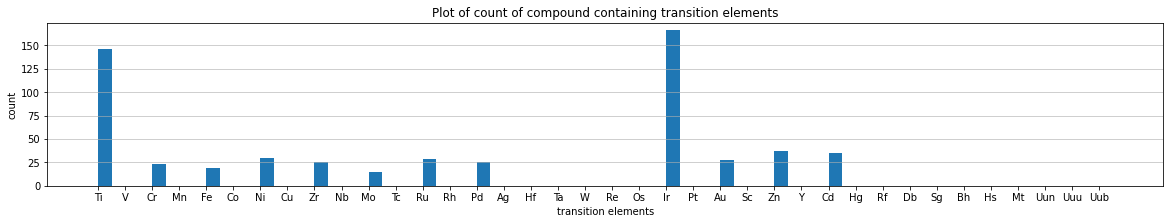

In [30]:
count = 0
d = { }

for ele in transition_metal_symbol:
    count = count +1
print("Count of transition element in dictionary ( x axis)")    
print(count)
#df_filtered_finished_data.Transition_Element

list_of_list_of_transition_metal = np.array(df_filtered_finished_data.Transition_Element)


#print(list_of_normalized_moment)
#print(list_of_list_of_transition_metal)
#transition_metal_symbol = ['Fe']

for ele in transition_metal_symbol:
    count = 0
    for each_list in df_filtered_finished_data.Transition_Element:
        if ele in each_list:
            count = count +1 
            #print(df_heatmap.normalized_moment)
    d[ele] = count
print("Presence of Transition Element in the data set :")
print(d)

plt.figure(figsize=(20, 3))  # width:20, height:3
#plt.bar(range(len(my_dict)), my_dict.values(), align='edge', width=0.3)

plt.bar(range(len(d)), list(d.values()), align='edge', width=0.5)
plt.xticks(range(len(d)), list(d.keys()))
plt.title('Plot of count of compound containing transition elements')
plt.xlabel('transition elements')
plt.ylabel('count')
plt.grid(axis='y', alpha=0.75)
plt.show()

Count of Halides in dictionary ( x axis)
4
Presence of Halides in the data set :
{'F': 0, 'Cl': 116, 'Br': 107, 'I': 87}


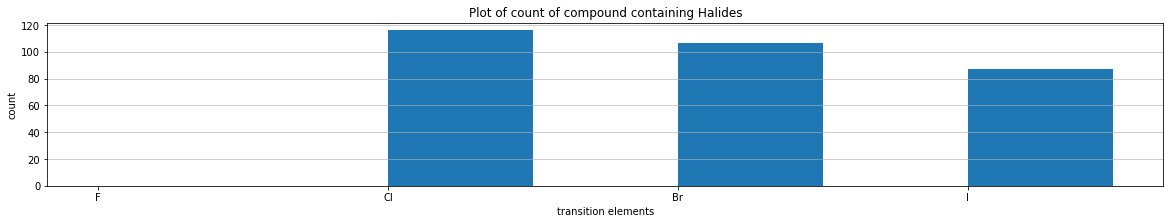

In [31]:
count = 0
d = { }

for ele in halide_symbol:
    count = count +1
print("Count of Halides in dictionary ( x axis)")    
print(count)
#df_filtered_finished_data.Transition_Element

list_of_list_of_halides = np.array(df_filtered_finished_data.Halides)

for ele in halide_symbol:
    count = 0
    for each_list in df_filtered_finished_data.Halides:
        if ele in each_list:
            count = count +1 
            #print(df_heatmap.normalized_moment)
    d[ele] = count
print("Presence of Halides in the data set :")
print(d)

plt.figure(figsize=(20, 3))  # width:20, height:3
#plt.bar(range(len(my_dict)), my_dict.values(), align='edge', width=0.3)

plt.bar(range(len(d)), list(d.values()), align='edge', width=0.5)
plt.xticks(range(len(d)), list(d.keys()))
plt.title('Plot of count of compound containing Halides')
plt.xlabel('transition elements')
plt.ylabel('count')
plt.grid(axis='y', alpha=0.75)
plt.show()

In [32]:
def add_descriptors_from_mendeleev(df):
    # add descriptors from medeleev package 
    # each property is multiplied with the count of individual atom and then added to get the sum for the compound
    rownum = len(df)

    
    total_electron_count = [] # addition of atomic no.
    
    total_nvalence = []
    total_heat_of_formation = []
    total_unpaired_electrons = []
    total_electron_affinity = []
    total_en_ghosh = []
    total_en_pauling = []
    total_dipole_polarizability = []

    for i in range(rownum) :
        total_electron_count_temp = 0
        
        total_nvalence_temp = 0
        total_heat_of_formation_temp = 0
        total_unpaired_electrons_temp = 0
        total_electron_affinity_temp = 0
        total_en_ghosh_temp = 0
        total_en_pauling_temp = 0
        total_dipole_polarizability_temp = 0
        
        
        composition = df.iloc[i]['composition']
        elements_present = list(composition.keys())

        
        for elem in elements_present: 
             
            atom_count = composition.get(elem)
            
            atomic_number = element(str(elem)).atomic_number
            
            dipole_polarizability = element(str(elem)).dipole_polarizability
            electron_affinity =element(str(elem)).electron_affinity
            en_ghosh = element(str(elem)).en_ghosh
            en_pauling = element(str(elem)).en_pauling
            nvalence =  element(str(elem)).nvalence()
            heat_of_formation = element(str(elem)).heat_of_formation
            electronic_config = element(str(elem)).ec
            unpaired_electrons = electronic_config.unpaired_electrons()
            

            
            total_electron_count_temp = total_electron_count_temp + (atomic_number*atom_count)
            
            total_nvalence_temp = total_nvalence_temp + (nvalence*atom_count)
            total_heat_of_formation_temp = total_heat_of_formation_temp + (heat_of_formation*atom_count)
            total_unpaired_electrons_temp = total_unpaired_electrons_temp + (unpaired_electrons*atom_count)
            
            total_electron_affinity_temp = total_electron_affinity_temp + ((float(0 if electron_affinity is None else electron_affinity))*atom_count)
                
            total_en_ghosh_temp = total_en_ghosh_temp + (en_ghosh*atom_count)
            total_en_pauling_temp = total_en_pauling_temp + (en_pauling*atom_count)
            total_dipole_polarizability_temp = total_dipole_polarizability_temp + (dipole_polarizability*atom_count)
        
            
        total_electron_count.append(total_electron_count_temp)
        
        total_nvalence.append(total_nvalence_temp)
        total_heat_of_formation.append(total_heat_of_formation_temp)
        total_unpaired_electrons.append(total_unpaired_electrons_temp)
        total_electron_affinity.append(total_electron_affinity_temp)
        total_en_ghosh.append(total_en_ghosh_temp)
        total_en_pauling.append(total_en_pauling_temp)
        total_dipole_polarizability.append(total_dipole_polarizability_temp)
    
        
    df['total_electron_count'] = total_electron_count
    
    df['total_nvalence'] = total_nvalence
    df['total_heat_of_formation'] = total_heat_of_formation
    df['total_unpaired_electrons'] = total_unpaired_electrons
    df['total_electron_affinity'] = total_electron_affinity
    df['total_en_ghosh'] = total_en_ghosh
    df['total_en_pauling'] = total_en_pauling
    df['total_dipole_polarizability'] = total_dipole_polarizability
    
    return df

In [33]:
df_filtered_finished_data = add_descriptors_from_mendeleev(df_filtered_finished_data)
count_row = df_filtered_finished_data.shape[0]  # Gives number of rows
count_col = df_filtered_finished_data.shape[1]  # Gives number of columns
print(count_row)

310


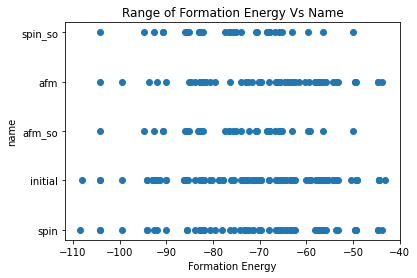

In [34]:
#plots to show the range of formation energy for different names

fig, ax = plt.subplots()

ax.scatter(df_filtered_finished_data['formation_energy'], df_filtered_finished_data['name'])
plt.title('Range of Formation Energy Vs Name')
plt.xlabel('Formation Energy')
plt.ylabel('name')

plt.show()

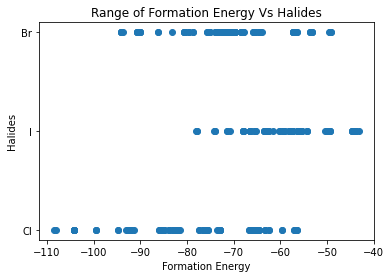

In [35]:

#plots to show the range of formation energy for different hallides
fig, ax2 = plt.subplots()

ax2.scatter(df_filtered_finished_data['formation_energy'], df_filtered_finished_data['Halides'])

plt.title('Range of Formation Energy Vs Halides')
plt.xlabel('Formation Energy')
plt.ylabel('Halides')

plt.show()

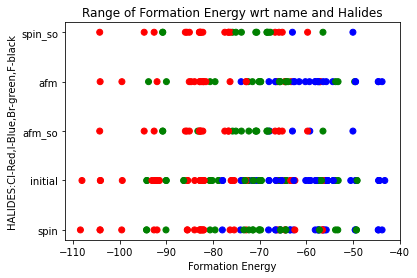

In [36]:
#plots to show the range of formation energy for different names
#the colors mark the three hallides available

fig, ax3 = plt.subplots()
colors = {"Cl":"red", "I":"blue", "Br":"green", "F":"black"}

ax3.scatter(df_filtered_finished_data['formation_energy'], df_filtered_finished_data['name'], c=df_filtered_finished_data['Halides'].apply(lambda x: colors[x]))

plt.title('Range of Formation Energy wrt name and Halides')
plt.xlabel('Formation Energy')
plt.ylabel('HALIDES:Cl-Red,I-Blue,Br-green,F-black')

plt.show()

       name Halides  formation_energy_mean
0       afm      Br             -68.395140
1       afm      Cl             -78.686096
2       afm       I             -57.698634
3    afm_so      Br             -73.992901
4    afm_so      Cl             -79.789141
5    afm_so       I             -60.064345
6   initial      Br             -71.055589
7   initial      Cl             -80.455748
8   initial       I             -59.692640
9      spin      Br             -68.664864
10     spin      Cl             -81.860745
11     spin       I             -59.127787
12  spin_so      Br             -73.094689
13  spin_so      Cl             -80.335591
14  spin_so       I             -56.533816


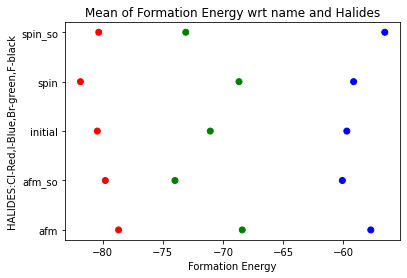

In [37]:
grouped_multiple = df_filtered_finished_data.groupby(['name', 'Halides']).agg({'formation_energy': ['mean']})
grouped_multiple.columns = ['formation_energy_mean']
grouped_multiple = grouped_multiple.reset_index()
print(grouped_multiple)

fig, ax4 = plt.subplots()
colors = {"Cl":"red", "I":"blue", "Br":"green", "F":"black"}

ax4.scatter(grouped_multiple['formation_energy_mean'], grouped_multiple['name'], c=grouped_multiple['Halides'].apply(lambda x: colors[x]))
plt.title('Mean of Formation Energy wrt name and Halides')
plt.xlabel('Formation Energy')
plt.ylabel('HALIDES:Cl-Red,I-Blue,Br-green,F-black')
plt.show()

In [38]:
grouped_multiple = df_filtered_finished_data.groupby(['name', 'Halides'])['formation_energy'].count()
#grouped_multiple.columns = ['formation_energy_mean']
grouped_multiple = grouped_multiple.reset_index()

print(grouped_multiple)
# Made a BiPartite graph for dynamic visualization

       name Halides  formation_energy
0       afm      Br                21
1       afm      Cl                20
2       afm       I                21
3    afm_so      Br                14
4    afm_so      Cl                19
5    afm_so       I                 4
6   initial      Br                35
7   initial      Cl                33
8   initial       I                39
9      spin      Br                24
10     spin      Cl                24
11     spin       I                20
12  spin_so      Br                12
13  spin_so      Cl                19
14  spin_so       I                 2


In [39]:
# corelation between formation energy and descriptor
# more correlated if close to 1
print(df_filtered_finished_data.columns)
df_energy_heatmap = df_filtered_finished_data[['relaxed_Energy', 'sum_individual_energy', 'formation_energy',
                                              'total_electron_count', 'total_nvalence', 'total_heat_of_formation',
                                           'total_unpaired_electrons', 'total_electron_affinity', 'total_en_ghosh',
                                           'total_en_pauling', 'total_dipole_polarizability']].copy()

Index(['Formula', 'Stacking', 'name', 'data', 'magmom_unitcell_x',
       'magmom_unitcell_y', 'magmom_unitcell_z', 'magmom_total', 'LOOP+',
       'NIONS', 'NKDIM', 'NBANDS', 'energy', 'stress', 'retry_count',
       'lattice_vecs', 'total charge', 'magnetization', 'position_force',
       'volume of cell', 'relaxed_Energy', 'sum_individual_energy',
       'elements_present', 'composition', 'formation_energy',
       'Transition_Element', 'Halides', 'total_electron_count',
       'total_nvalence', 'total_heat_of_formation', 'total_unpaired_electrons',
       'total_electron_affinity', 'total_en_ghosh', 'total_en_pauling',
       'total_dipole_polarizability'],
      dtype='object')


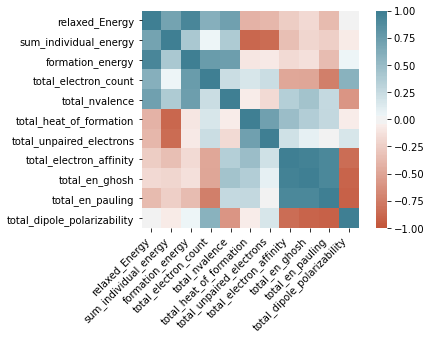

In [40]:
corr = df_energy_heatmap.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

In [41]:
df_filtered_finished_data.to_csv('BiLayer_Data.csv')

In [ ]:
#visualization : 